In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested',\
                       chunks={'Time':1, 'bottom_top':1, 'bottom_top_stag':1, 'west_east':-1, 'south_north':-1, \
                               'west_east_stag':'auto', 'south_north_stag':'auto', 'soil_layers_stag' : 'auto' , 'seed_dim_stag' : 'auto'})


In [4]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# select domain
mask_lon = (ds.XLONG >= minlon) & (ds.XLONG <= maxlon)
mask_lat = (ds.XLAT >= minlat) & (ds.XLAT <= maxlat)
# mask = (mask_lon & mask_lat).compute()

In [5]:
'''mask_nan = xr.where(mask<1. , np.nan, 1.)'''

'mask_nan = xr.where(mask<1. , np.nan, 1.)'

In [6]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

In [7]:
full_mask = np.load('/venus/tesi_ale/data_EU_forced/full_mask.npy')

full_mask = xr.DataArray(
    full_mask,
    dims=('south_north', 'west_east'),
    coords={
        # 'south_north': ds.dims['south_north'],
        # 'west_east': ds.dims['west_east'],
        'XLAT': (('south_north', 'west_east'), ds.XLAT[0].values),
        'XLONG': (('south_north', 'west_east'), ds.XLONG[0].values),
    }
)


In [8]:
mask_lon_local, mask_lat_local = mask_lon[0].compute(), mask_lat[0].compute()
reduced_full_mask = full_mask.where(mask_lon_local & mask_lat_local, drop=True)

In [9]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/3)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/3)
nttop = int(1)

# reference population mean
popmean = 0.

In [8]:
########################################################################à

In [6]:
# reading geopotential height
GPH_base = ds['PHB']/9.81
GPH = ds['PH']/9.81

GPH = GPH_base + GPH
GPH = GPH.transpose('bottom_top_stag', 'Time', 'south_north', 'west_east')

# GPH = GPH.where(full_mask, drop=False)

GPH = GPH.resample(XTIME='24H').mean(dim = 'Time')
# GPH = GPH.rename({'XTIME':'Time'})
del GPH_base

In [7]:
# # vertical interpolation of geopotential
# # GPH_inter = np.zeros((39,29,546,573))
# # for i in range(39):
# #     GPH_inter[i,:,:,:] = (GPH[i+1,:,:,:]+GPH[i,:,:,:])*0.5

GPH_lower = GPH.isel(bottom_top_stag=slice(0, -1))
GPH_upper = GPH.isel(bottom_top_stag=slice(1, None))

# ## THERE WAS A MISMATCH BETWEEN THE lev_W labels
# ## this .data allows to disregard the labels (treats them as Numpy arrays)
GPH_inter = xr.DataArray(0.5*(GPH_lower.data + GPH_upper.data), dims=('bottom_top', 'XTIME', 'south_north', 'west_east'))


# del GPH_inter

In [8]:
print(GPH.dims)
print(GPH_inter.dims)
del GPH

('bottom_top_stag', 'XTIME', 'south_north', 'west_east')
('bottom_top', 'XTIME', 'south_north', 'west_east')


In [9]:
PBLH_day = ds['PBLH'].resample(XTIME='24H').mean(dim = 'Time')
PBLH_day = PBLH_day.where(full_mask, drop=False)

PBLH_exp = PBLH_day.expand_dims(dim={"bottom_top": GPH_inter.sizes["bottom_top"]}, axis=0)
PBLH_exp = PBLH_exp.chunk({'bottom_top':1, 'XTIME':1, 'south_north':-1, 'west_east':-1})

In [11]:
dZ = GPH.diff('bottom_top_stag', n=1)
# if 'lev_W' in dZ.dims:
    # dZ = dZ.rename({'lev_W':'lev_M'})

# dZ = dZ.assign_coords({'Time': PBLH_exp.time_counter})

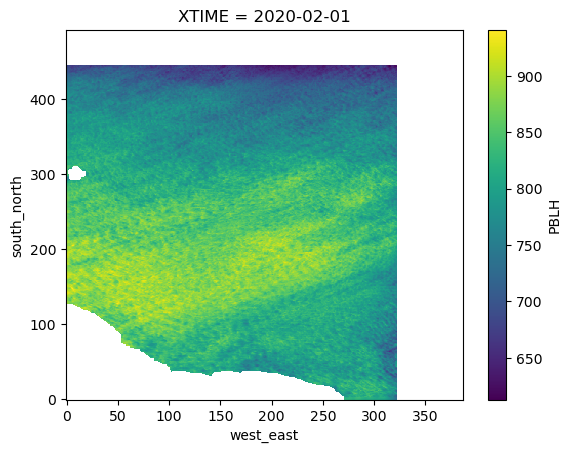

In [10]:
GPH_inter = GPH_inter*full_mask
PBLH_exp = PBLH_exp*full_mask
PBLH_exp[10,0].plot()

In [10]:
under_mabl = xr.where(GPH_inter <= PBLH_exp, 1.0, 0.0)
# under_mabl inherits the time_counter from PBLH_exp
# I DON'T UNDERSTAND WHY THE THING WAS COMPLAINING IN THE COUPLED SCRIPTS
# FOR THE DIFFERENT LABELS OR VALUES ALONG THE TIME DIMENSION
# WHEREAS IT IS NOT COMPLAINING HERE

# access days of datetime64 array like
# under_mabl.XTIME[10].dt.day.values

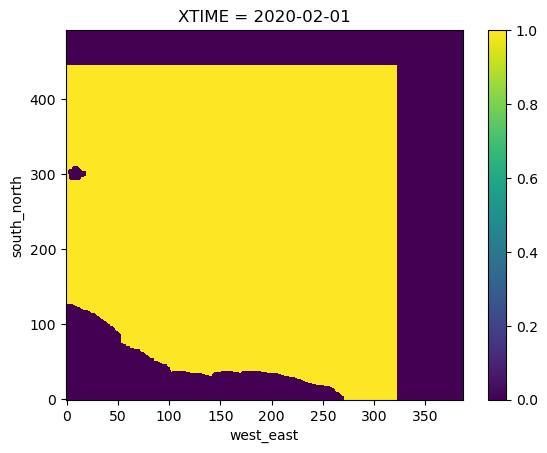

In [17]:
under_mabl[0,0].plot()

In [23]:
# mask_npy = under_mabl[0,0].compute()
# mask_npy.to_netcdf('/venus/tesi_ale/data_EU_forced/full_mask_forced.nc')

### July 2025: analyze $\int_{MABL} \theta \, dz$ to link WRF to bulk model

In [12]:
# reading temperature
# pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')], chunks={'time_counter':1, 'lev_M':1, 'y_grid_M':-1, 'x_grid_M':-1})
pot_temp = ds['T']
# pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
# pot_temp = pot_temp.where(seamask, drop=False)
# pot_temp = pot_temp.groupby('time_counter.day').mean()

T0 = 300.
pot_temp_full = pot_temp + T0
del pot_temp

In [13]:
pot_temp_full.dims

('Time', 'bottom_top', 'south_north', 'west_east')

In [14]:
theta_day = pot_temp_full.resample(XTIME='24H').mean(dim = 'Time');
theta_day = theta_day.transpose('bottom_top', 'XTIME', 'south_north', 'west_east')
theta_day = theta_day*full_mask
del pot_temp_full

In [15]:
theta_day.dims

('bottom_top', 'XTIME', 'south_north', 'west_east')

In [16]:
under_mabl.dims

('bottom_top', 'XTIME', 'south_north', 'west_east')

In [17]:
# theta_day = theta_day.assign_coords({'XTIME': PBLH_exp.time_counter})

In [18]:
theta_day_avg = theta_day.where(under_mabl, drop=False).mean(dim='bottom_top', skipna=True)

In [59]:
theta_day_avg

<xarray.DataArray 'T' (XTIME: 29, south_north: 446, west_east: 323)>
dask.array<mean_agg-aggregate, shape=(29, 446, 323), dtype=float32, chunksize=(1, 446, 323), chunktype=numpy.ndarray>
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 2020-02-01 2020-02-02 ... 2020-02-29
Dimensions without coordinates: south_north, west_east

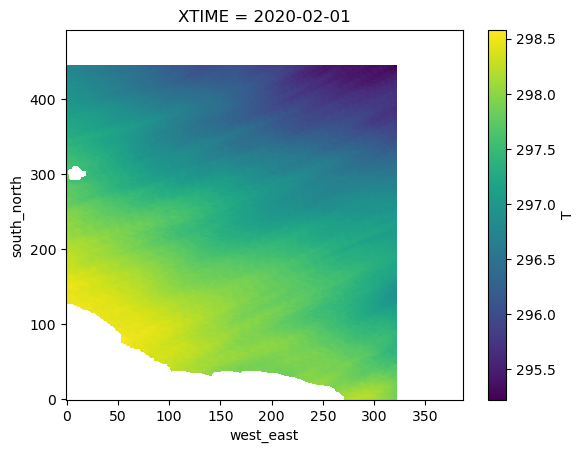

In [19]:
theta_day_avg[0].plot()

In [20]:
theta_day_avg.attrs['long name'] = 'FORCED SIMULATION: average potential temperature within the simulated MABL depth'
theta_day_avg.attrs['units'] = '[K]'
# theta_day_avg = theta_day_avg.chunk({'time_counter':1, 'y_grid_M':-1, 'x_grid_M':-1})


In [21]:
if os.path.exists('/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_theta_MABL.nc'):
    print('file forced_theta_MABL.nc already exists - deleting and saving again')
    os.remove('/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_theta_MABL.nc')
theta_day_avg.to_netcdf(path='/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_theta_MABL.nc', compute=True)

In [6]:
# import zarr
# from pathlib import Path

# # Use DirectoryStore to avoid ambiguity
# store = zarr.DirectoryStore("/venus/tesi_ale/data_EU/integrated_MABL_vars/theta_MABL.zarr")

# # 
# theta_day_avg.to_zarr(store="/venus/tesi_ale/data_EU/integrated_MABL_vars/theta_MABL.zarr", mode="w", safe_chunks=False)

try to read this chunked netCDF file

In [14]:
ds = ds.chunk({'time_counter':1})

the chunking was not saved!!

something like this should preserve the dask-backed chunking

ds = theta_day_avg.to_dataset(name='theta')
encoding = {'theta': {'chunksizes': theta_day_avg.chunks}}
ds.to_netcdf(
    path='/venus/tesi_ale/data_EU/integrated_MABL_vars/theta_MABL.nc',
    encoding=encoding,
    compute=True
)

## Quickly check whether what I get makes sense

In [10]:
theta_ds = xr.open_dataset('/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_theta_MABL.nc')
theta_ds = theta_ds.rename({'XTIME':'day'})

In [11]:
theta = theta_ds['T'].where(mask_lon_local & mask_lat_local, drop=True)*reduced_full_mask

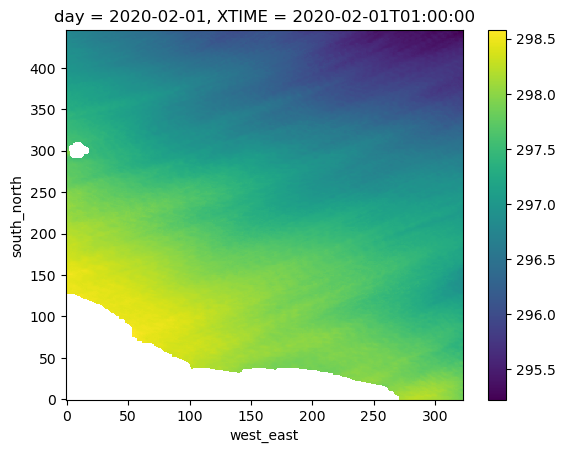

In [26]:
theta[0].plot()

In [15]:
sst_day = ds['SST'].resample(XTIME='24H').mean(dim = 'Time')
sst_day = sst_day.rename({'XTIME':'day'})
# sst_day = sst_day.where(seamask, drop=False).values*seamask
sst_day = sst_day.where(mask_lon_local & mask_lat_local, drop=True)*reduced_full_mask

In [16]:
s = 50

dsst_day = np.zeros(sst_day.shape)
dTheta_avg = np.zeros(theta.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t].values, s)                             
    dsst_day[t] = sst_day[t].values - sst_ave
    
    t_ave = gm.nan_gaussian_filter(theta[t].values, s)                             
    dTheta_avg[t] = theta[t].values - t_ave

0
10
20


Text(0.5, 1.0, 'Theta')

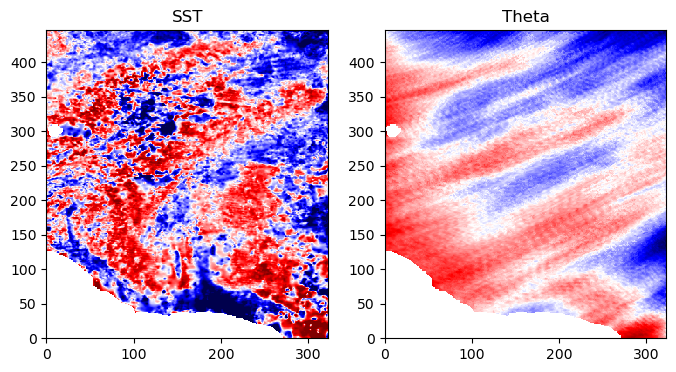

In [18]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].pcolormesh(dsst_day[0], cmap='seismic', vmin=-0.5, vmax=0.5)
ax[0].set_title('SST')

ax[1].pcolormesh(dTheta_avg[0], cmap='seismic', vmin=-0.5, vmax=0.5)
ax[1].set_title('Theta')

In [43]:
perc_step = 1
nbins = int(100/perc_step) # Number of bins.
popmean = 0.

pdist_dsst, pdist_ThetaAvg_dsst, pstd_ThetaAvg_dsst, pstderr_ThetaAvg_dsst, pnpoints_ThetaAvg_dsst, ppvalue_ThetaAvg_dsst = \
distrib_2d(dsst_day, dTheta_avg, perc_step, nbins, popmean, 'perc')

In [44]:
dTheta_avg.shape == dsst_day.shape

True

slope coeff = 0.19 K/K


Text(0, 0.5, "$\\overline{\\theta_{MABL}}'$ [K]")

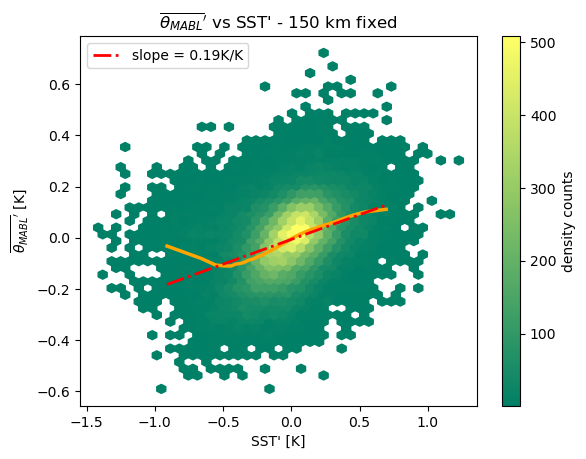

In [77]:
x = dsst_day[::nt,::nskip,::nskip].flatten()
y = dTheta_avg[::nt,::nskip,::nskip].flatten()

fit_dsens_dsst, corcoe_dsens_dsst, p_value_dsens_dsst, p_value_cannelli_dsens_dsst, sigmas_coeffs_dsens_dsst =\
slopes_r_p_mix(dsst_day, dTheta_avg, nt, nskip)

print(f"slope coeff = {fit_dsens_dsst.slope:.2f} K/K")

bins = plt.hexbin(x,y, gridsize=(40,25), mincnt=1, cmap='summer')
plt.colorbar(bins, label='density counts')
plt.plot(pdist_dsst, pdist_ThetaAvg_dsst, color='orange', linewidth=2.5)
plt.plot(pdist_dsst, fit_dsens_dsst.slope*pdist_dsst+fit_dsens_dsst.intercept, color='red', linestyle='-.', linewidth=2, \
        label = f"slope = {fit_dsens_dsst.slope:.2f}"+"K/K")

plt.legend(loc='upper left')

plt.title(r"$\overline{\theta_{MABL}}'$ vs SST' -"+ f" {3*s} km fixed")
plt.xlabel("SST' [K]")
plt.ylabel(r"$\overline{\theta_{MABL}}'$ [K]")

In [ ]:
## TO BE RUN
## UNDERSTAND WHAT IT IS THAT'S TAKING UP SO MUCH MEMORY / TIME

where_not_nan = ~np.isnan(y) & ~np.isnan(x)
res = stats.theilslopes(y[where_not_nan], x[where_not_nan], alpha=0.95)
print(f"slope = {res.slope}")
print(f"contained between {res.low_slope} and {res.high_slope}")

## Are slopes scale-dependent?

In [23]:
scales = np.arange(5, 120, 10)
scales_km = list(3*scales)
scales_km = [str(i) for i in scales_km]
# scales_km = [str(i)+' km' for i in scales_km]

import pandas as pd

df_index = ['fit', 'corr', 'p_val', 'p_val_cannelli', 'sigmas']
fit_results = pd.DataFrame(data=None, index = df_index, columns=scales)



In [24]:
for i in range(scales.shape[0]):
    ThetaAvg_prime = np.zeros(theta.shape)
    sst_prime = np.zeros(sst_day.shape)

    for t in range(0,theta.shape[0]):
        # upscale using gaussian filter
        ThetaAvg_smooth = gm.nan_gaussian_filter(theta[t], scales[i])                             
        ThetaAvg_prime[t] = theta[t] - ThetaAvg_smooth

        sst_day_smooth = gm.nan_gaussian_filter(sst_day[t], scales[i])                             
        sst_prime[t] = sst_day[t] - sst_day_smooth
        
    result_list = slopes_r_p_mix(sst_prime, ThetaAvg_prime, nt, nskip, ls = True)
    fit_results.loc[:,scales[i]] = result_list
    print(f"step {i} done")

step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done
step 6 done
step 7 done
step 8 done
step 9 done
step 10 done
step 11 done


In [29]:
fit_results

,5,15,25,35,45,55,65,75,85,95,105,115
fit,"(0.02655677820775196, -0.00012352494365170514,...","(0.055545233640718866, -0.0009960629200372088,...","(0.08757972006118753, -0.002305684071854589, 0...","(0.12637581456933653, -0.003928570161489508, 0...","(0.17017197903508607, -0.005724019721096992, 0...","(0.2166051950303988, -0.007478003459890185, 0....","(0.2646826733830779, -0.009008972264560343, 0....","(0.31434351637774105, -0.010208542462539466, 0...","(0.36540959356495706, -0.01103300304896862, 0....","(0.417020681914794, -0.011491979449840194, 0.5...","(0.4678589620002854, -0.011631224356834655, 0....","(0.5166714880130505, -0.011512296445759587, 0...."
corr,0.14575,0.228228,0.276359,0.329468,0.380598,0.423757,0.460187,0.49293,0.523535,0.551905,0.577436,0.599798
p_val,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p_val_cannelli,0.001955,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sigmas,"(0.00857436321353189, 0.00082829739152799)","(0.011738755467079025, 0.0018164098519021744)","(0.015635836591528392, 0.0029433657305041635)","(0.01912863796303688, 0.004137287253924814)","(0.022229027338605906, 0.00534155931094032)","(0.025046495988782985, 0.006524227806167326)","(0.027667715924494345, 0.007677311131448085)","(0.030104834821620196, 0.00879494407780309)","(0.03231039523227265, 0.009864197698210479)","(0.03422888237669226, 0.01086860564204672)","(0.035832839155388596, 0.01179443942971926)","(0.03713230461373164, 0.01263510416804924)"


In [25]:
slopes_only = [fit_results.loc['fit', scales[i]].slope for i in range(len(scales))]
sigma_slope = [fit_results.loc['sigmas', scales[i]][0] for i in range(len(scales))]
corr = [fit_results.loc['corr', scales[i]] for i in range(len(scales))]


Text(0.5, 0.98, "$\\overline{\\theta_{MABL}'}$ vs SST' dependence")

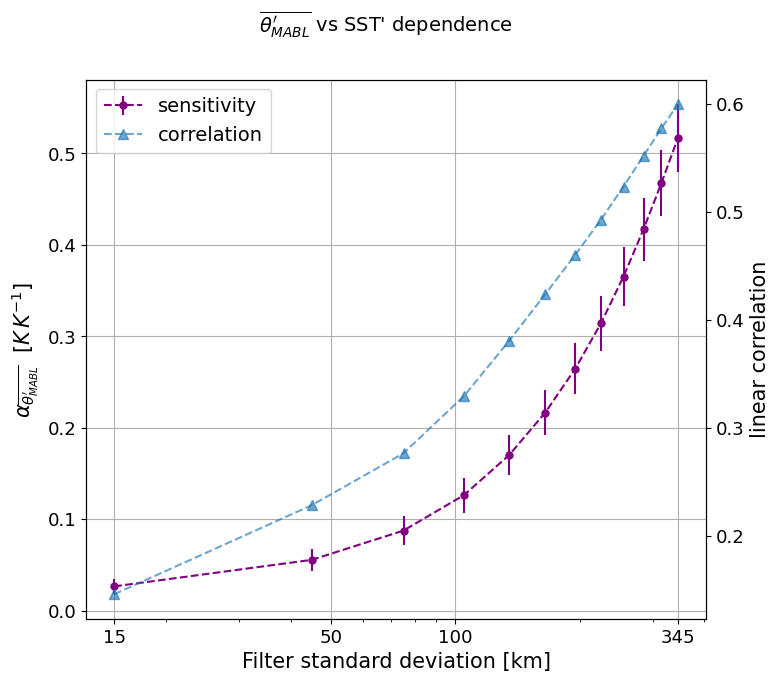

In [41]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

# slopes_plot = ax.errorbar(scales, slopes_only, yerr=sigma_slope, xerr=None, color='r', label='std dev.')#, marker='s', mfc='red',mec='green', ms=20, mew=4)
slopes_plot = ax.errorbar(
    3*scales, 
    slopes_only, 
    yerr=sigma_slope, 
    xerr=None, 
    color='purple',          # Set line color to orange
    fmt='o',                 # Circular markers
    markersize=5,            # Marker size
    ecolor='purple',         # Error bar color to match the line color
    linestyle='--',          # Dashed error bars
    label='sensitivity'
)
ax.set_ylabel(r"$\alpha_{\overline{\theta_{MABL}'}}$  [$K\,K^{-1}$]", fontsize=15)
ax.set_xscale('log')

# ax.set_xticks(scales)
# ax.set_xticklabels(scales_km)
ax.set_xlabel('Filter standard deviation [km]', fontsize=15)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=13)


#################################################

ax1 = ax.twinx()
corr_plot = ax1.plot(3*scales, corr, '^--', markersize=7, label='correlation', alpha=0.65)
ax1.set_ylabel('linear correlation', fontsize=15)
ax1.set_xscale('log')
ax1.set_xticks([3*scales[0], 50, 100, 3*scales[-1]])  # Example for adding multiple ticks
ax1.set_xticklabels([str(3*scales[0]), '50', '100', str(3*scales[-1])]) 

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=14)


ax1.tick_params(axis='both', which='major', labelsize=13)

fig.suptitle(r"$\overline{\theta_{MABL}'}$ vs SST' dependence", fontsize=14)


# path_img = '/venus/tesi_ale/plots_forced_EU/ThermContr_\theta_{MABL}_only/' 
# filename = path_img + '\theta_{MABL}_scale_sensitvity_correlation.png'
# plt.savefig(filename)
# print(filename)
# del filename



In [ ]:
del theta, theta_ds

## $\int_{MABL} QVAPOR$

In [53]:
# QVAPOR = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')], chunks={'time_counter':1, 'lev_M':1, 'y_grid_M':-1, 'x_grid_M':-1})
QVAPOR = ds['QVAPOR']  #.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

QVAPOR = QVAPOR.resample(XTIME='24H').mean(dim = 'Time')
QVAPOR = QVAPOR.transpose('bottom_top', 'XTIME', 'south_north', 'west_east')

In [54]:
QVAPOR = QVAPOR.assign_coords({'XTIME': PBLH_exp.XTIME})
QVAPOR = QVAPOR.where(under_mabl, drop=False).mean(dim='bottom_top', skipna=True)

In [55]:
QVAPOR

<xarray.DataArray 'QVAPOR' (XTIME: 29, south_north: 492, west_east: 387)>
dask.array<mean_agg-aggregate, shape=(29, 492, 387), dtype=float32, chunksize=(1, 492, 387), chunktype=numpy.ndarray>
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 2020-02-01 2020-02-02 ... 2020-02-29
Dimensions without coordinates: south_north, west_east

In [56]:
QVAPOR.attrs['long name'] = 'FORCED SIMULATION: average QVAPOR mixing ratio within the simulated MABL depth'
QVAPOR.attrs['units'] = '[kg / kg]'


if os.path.exists('/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_QVAPOR_MABL.nc'):
    print('file forced_theta_MABL.nc already exists - deleting and saving again')
    os.remove('/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_QVAPOR_MABL.nc')
QVAPOR.to_netcdf(path='/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_QVAPOR_MABL.nc', compute=True)

In [35]:
QVAPOR_ds = xr.open_dataset('/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_QVAPOR_MABL.nc')
QVAPOR_ds = QVAPOR_ds.rename({'XTIME':'day'})

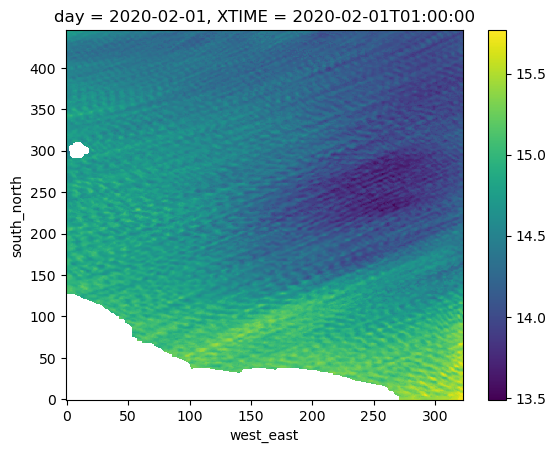

In [38]:
QVAPOR = QVAPOR_ds['QVAPOR'].where(mask_lon_local & mask_lat_local, drop=True)*reduced_full_mask*1e3
QVAPOR[0].plot()

In [ ]:
sst_day = ds['SST'].resample(XTIME='24H').mean(dim = 'Time')          
# sst_day = sst_day.where(seamask, drop=False).values*seamask
sst_day = sst_day.values*full_mask

In [39]:
s = 50

dsst_day = np.zeros(sst_day.shape)
dQvapAvg = np.zeros(QVAPOR.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t], s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    q_ave = gm.nan_gaussian_filter(QVAPOR[t], s)                             
    dQvapAvg[t] = QVAPOR[t] - q_ave

NameError: name 'sst_day' is not defined

In [66]:
dQvapAvg = dQvapAvg*full_mask

In [67]:
perc_step = 1
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dQvapAvg_dsst, pstd_dQvapAvg_dsst, pstderr_dQvapAvg_dsst, pnpoints_dQvapAvg_dsst, ppvalue_dQvapAvg_dsst = \
distrib_2d(dsst_day, dQvapAvg, perc_step, nbins, popmean, 'perc')

slope coeff = -0.05 K/K


Text(0, 0.5, "$\\overline{q_{MABL}}'$ [$g\\,kg^{-1}$]")

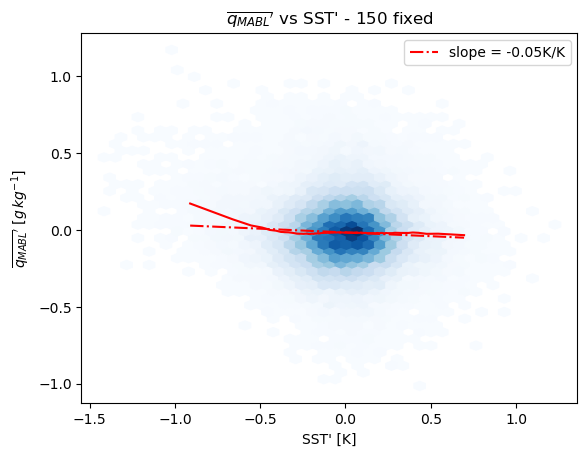

In [71]:
x = dsst_day[::nt,::nskip,::nskip].flatten()
y = dQvapAvg[::nt,::nskip,::nskip].flatten()

fit_dQvapAvg_dsst, corcoe_dQvapAvg_dsst, p_value_dQvapAvg_dsst, p_value_cannelli_dQvapAvg_dsst, sigmas_coeffs_dQvapAvg_dsst =\
slopes_r_p_mix(dsst_day, dQvapAvg, nt, nskip)

print(f"slope coeff = {fit_dQvapAvg_dsst.slope:.2f} K/K")

plt.hexbin(x,y, gridsize=(40,25), mincnt=1, cmap='Blues')
plt.plot(pdist_dsst, pdist_dQvapAvg_dsst, color='red')
plt.plot(pdist_dsst, fit_dQvapAvg_dsst.slope*pdist_dsst+fit_dQvapAvg_dsst.intercept, color='red', linestyle='-.', \
         label = f"slope = {fit_dQvapAvg_dsst.slope:.2f}"+"K/K")

plt.legend()
plt.title(r"$\overline{q_{MABL}}'$ vs SST'"+f" - {3*s} fixed" )
plt.xlabel("SST' [K]")
plt.ylabel(r"$\overline{q_{MABL}}'$ [$g\,kg^{-1}$]")

In [72]:
scales = np.arange(5, 120, 10)
scales_km = list(3*scales)
scales_km = [str(i) for i in scales_km]
# scales_km = [str(i)+' km' for i in scales_km]

import pandas as pd

df_index = ['fit', 'corr', 'p_val', 'p_val_cannelli', 'sigmas']
fit_results_q = pd.DataFrame(data=None, index = df_index, columns=scales)


In [74]:
for i in range(scales.shape[0]):
    Q_prime = np.zeros(QVAPOR.shape)
    sst_prime = np.zeros(sst_day.shape)

    for t in range(0,QVAPOR.shape[0]):
        # upscale using gaussian filter
        ThetaAvg_smooth = gm.nan_gaussian_filter(QVAPOR[t]*full_mask, scales[i])                             
        Q_prime[t] = QVAPOR[t]*full_mask - ThetaAvg_smooth

        sst_day_smooth = gm.nan_gaussian_filter(sst_day[t], scales[i])                             
        sst_prime[t] = sst_day[t] - sst_day_smooth
        
    result_list = slopes_r_p_mix(sst_prime, Q_prime, nt, nskip, ls = True)
    fit_results_q.loc[:,scales[i]] = result_list
    print(f"step {i} done")


step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done
step 6 done
step 7 done
step 8 done
step 9 done
step 10 done
step 11 done


In [75]:
slopes_only = [fit_results_q.loc['fit', scales[i]].slope for i in range(len(scales))]
sigma_slope = [fit_results_q.loc['sigmas', scales[i]][0] for i in range(len(scales))]
corr = [fit_results_q.loc['corr', scales[i]] for i in range(len(scales))]

Text(0.5, 0.98, "$\\overline{q_{MABL}'}$ vs SST' dependence")

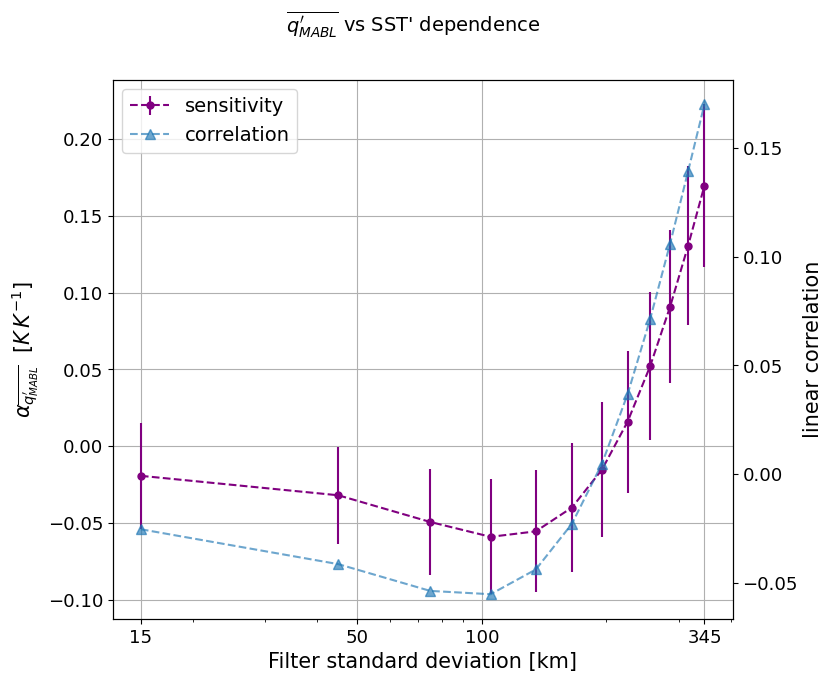

In [76]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

# slopes_plot = ax.errorbar(scales, slopes_only, yerr=sigma_slope, xerr=None, color='r', label='std dev.')#, marker='s', mfc='red',mec='green', ms=20, mew=4)
slopes_plot = ax.errorbar(
    3*scales, 
    slopes_only, 
    yerr=sigma_slope, 
    xerr=None, 
    color='purple',          # Set line color to orange
    fmt='o',                 # Circular markers
    markersize=5,            # Marker size
    ecolor='purple',         # Error bar color to match the line color
    linestyle='--',          # Dashed error bars
    label='sensitivity'
)
ax.set_ylabel(r"$\alpha_{\overline{q_{MABL}'}}$  [$K\,K^{-1}$]", fontsize=15)
ax.set_xscale('log')

# ax.set_xticks(scales)
# ax.set_xticklabels(scales_km)
ax.set_xlabel('Filter standard deviation [km]', fontsize=15)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=13)


#################################################

ax1 = ax.twinx()
corr_plot = ax1.plot(3*scales, corr, '^--', markersize=7, label='correlation', alpha=0.65)
ax1.set_ylabel('linear correlation', fontsize=15)
ax1.set_xscale('log')
ax1.set_xticks([3*scales[0], 50, 100, 3*scales[-1]])  # Example for adding multiple ticks
ax1.set_xticklabels([str(3*scales[0]), '50', '100', str(3*scales[-1])]) 

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=14)


ax1.tick_params(axis='both', which='major', labelsize=13)

fig.suptitle(r"$\overline{q_{MABL}'}$ vs SST' dependence", fontsize=14)


# path_img = '/venus/tesi_ale/plots_forced_EU/ThermContr_\theta_{MABL}_only/' 
# filename = path_img + '\theta_{MABL}_scale_sensitvity_correlation.png'
# plt.savefig(filename)
# print(filename)
# del filename



## $\int_{MABL} WINDSPEED$

In [13]:
'''mask_lon_ws = (ds['V'].XLONG_V >= minlon) & (ds['V'].XLONG_V <= maxlon)
mask_lat_ws = (ds['V'].XLAT_V >= minlat) & (ds['V'].XLAT_V <= maxlat)
mask_ws = (mask_lon_ws & mask_lat_ws).compute()

v = ds['V'].where(mask_ws, drop=True)'''

In [15]:
'''minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.

mask_lon_ws = (ds['U'].XLONG_U >= minlon) & (ds['U'].XLONG_U <= maxlon)
mask_lat_ws = (ds['U'].XLAT_U >= minlat) & (ds['U'].XLAT_U <= maxlat)
mask_ws = (mask_lon_ws & mask_lat_ws).compute()

u = u.where(mask_ws, drop=True)
# '''

In [11]:
ds['U'].dims

('Time', 'bottom_top', 'south_north', 'west_east_stag')

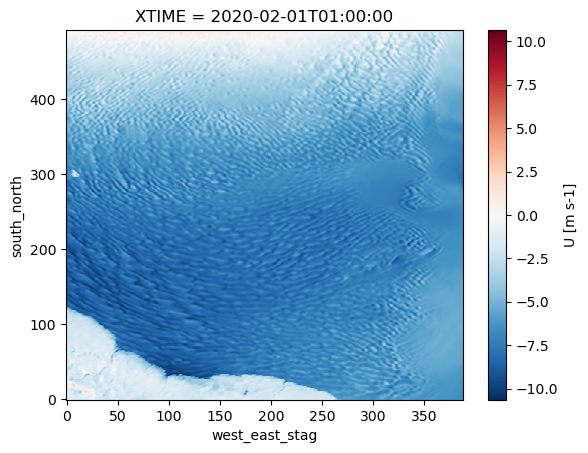

In [13]:
ds['U'][0,0,:,:].plot()

In [29]:
u_lower = ds['U'].isel(west_east_stag=slice(0, -1))
u_upper = ds['U'].isel(west_east_stag=slice(1, None))

u = 0.5*(u_lower+u_upper)
u = u.rename({'west_east_stag':'west_east'})


v_lower = ds['V'].isel(south_north_stag=slice(0, -1))
v_upper = ds['V'].isel(south_north_stag=slice(1, None))

v = 0.5*(v_lower+v_upper)
v = v.rename({'south_north_stag':'south_north'})

In [37]:
u = u.transpose('bottom_top', 'XTIME', 'south_north', 'west_east')
v = v.transpose('bottom_top', 'XTIME', 'south_north', 'west_east')


In [39]:
# u_mabl = u.where(under_mabl, drop=False).mean(dim='bottom_top', skipna=True)
# v_mabl = v.where(under_mabl, drop=False).mean(dim='bottom_top', skipna=True)

In [40]:
wind_sp_mabl = ((u**2)+(v**2))**(0.5)
wind_sp_mabl = wind_sp_mabl.resample(XTIME='24H').mean(dim='XTIME')*full_mask

In [41]:
wind_sp_mabl = wind_sp_mabl.assign_coords({'XTIME': PBLH_exp.XTIME})
wind_sp_mabl = wind_sp_mabl.where(under_mabl, drop=False).mean(dim='bottom_top', skipna=True)

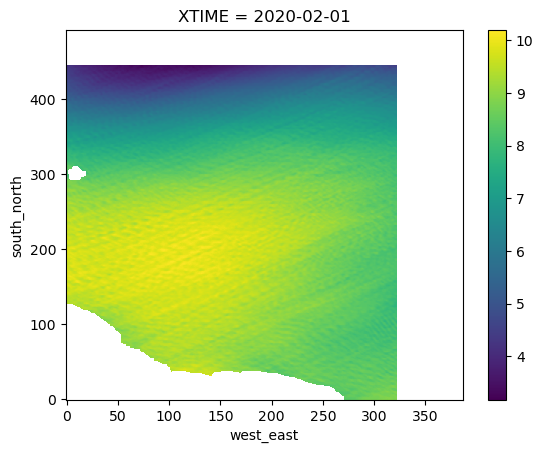

In [43]:
wind_sp_mabl[0].plot()

In [44]:
ws_vals = wind_sp_mabl.values

In [ ]:
sst_day = ds['SST'].resample(XTIME='24H').mean(dim = 'Time')          
# sst_day = sst_day.where(seamask, drop=False).values*seamask
sst_day = sst_day.values*full_mask

In [47]:
perc_step = 1
nbins = int(100/perc_step) # Number of bins.

pdist_sst, pdist_WSAvg_sst, pstd_WSAvg_sst, pstderr_WSAvg_sst, pnpoints_WSAvg_sst, ppvalue_WSAvg_sst = \
distrib_2d(sst_day, ws_vals, perc_step, nbins, popmean, 'perc')

slope coeff = -0.19 m/s/K


Text(0, 0.5, '$WS_{MABL}$ [K]')

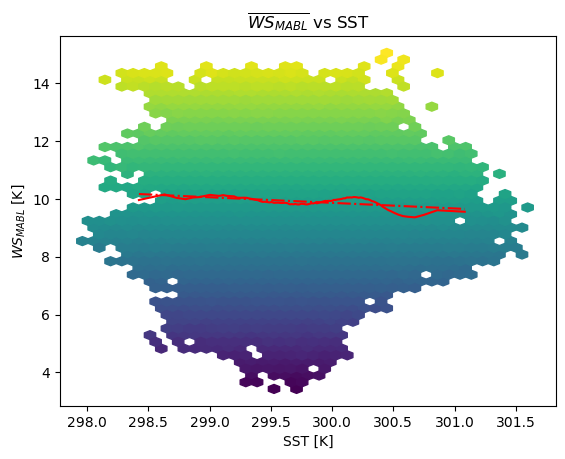

In [48]:
x = sst_day[::nt,::nskip,::nskip].flatten()
y = ws_vals[::nt,::nskip,::nskip].flatten()

fit_dsens_dsst, corcoe_dsens_dsst, p_value_dsens_dsst, p_value_cannelli_dsens_dsst, sigmas_coeffs_dsens_dsst =\
slopes_r_p_mix(sst_day, ws_vals, nt, nskip)

print(f"slope coeff = {fit_dsens_dsst.slope:.2f} m/s/K")

plt.hexbin(x,y,C=y, gridsize=(40,25))
plt.plot(pdist_sst, pdist_WSAvg_sst, color='red')
plt.plot(pdist_sst, fit_dsens_dsst.slope*pdist_sst+fit_dsens_dsst.intercept, color='red', linestyle='-.')

plt.title(r"$\overline{WS_{MABL}}$ vs SST")
plt.xlabel("SST [K]")
plt.ylabel(r"$WS_{MABL}$ [K]")

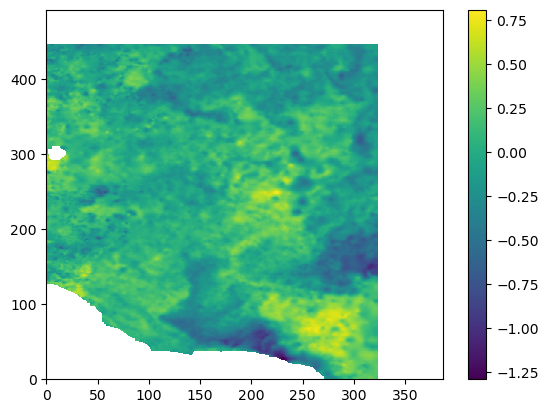

In [55]:
plt.pcolormesh(dsst_day[10])
plt.colorbar()

In [49]:
s = 50

dsst_day = np.zeros(sst_day.shape)
dws = np.zeros(ws_vals.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t], s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    t_ave = gm.nan_gaussian_filter(ws_vals[t], s)                             
    dws[t] = ws_vals[t] - t_ave

0
10
20


In [57]:
perc_step = 1
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dWS_dsst, pstd_dWS_dsst, pstderr_dWS_dsst, pnpoints_dWS_dsst, ppvalue_dWS_dsst = \
distrib_2d(dsst_day, dws, perc_step, nbins, popmean, 'perc')

slope coeff = 0.12 m/s/K


Text(0, 0.5, "$WS'_{MABL}$ [K]")

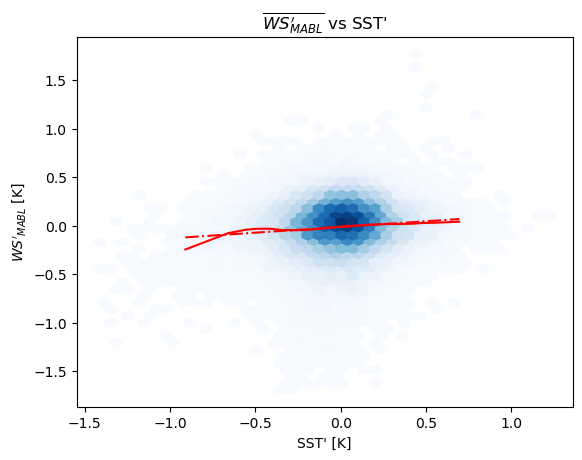

In [59]:
x = dsst_day[::nt,::nskip,::nskip].flatten()
y = dws[::nt,::nskip,::nskip].flatten()

fit_dsens_dsst, corcoe_dsens_dsst, p_value_dsens_dsst, p_value_cannelli_dsens_dsst, sigmas_coeffs_dsens_dsst =\
slopes_r_p_mix(dsst_day, dws, nt, nskip)

print(f"slope coeff = {fit_dsens_dsst.slope:.2f} m/s/K")

plt.hexbin(x,y, gridsize=(40,25), mincnt=1, cmap='Blues')
plt.plot(pdist_dsst, pdist_dWS_dsst, color='red')
plt.plot(pdist_dsst, fit_dsens_dsst.slope*pdist_dsst+fit_dsens_dsst.intercept, color='red', linestyle='-.')

plt.title(r"$\overline{WS_{MABL}'}$ vs SST'")
plt.xlabel("SST' [K]")
plt.ylabel(r"$WS'_{MABL}$ [K]")

In [60]:
wind_sp_mabl.attrs['long name'] = 'FORCED SIMULATION: average Wind Speed within the simulated MABL depth'
wind_sp_mabl.attrs['units'] = '[m / s]'

wind_sp_mabl.to_netcdf(path='/venus/tesi_ale/data_EU_forced/forced_MABL_integration/forced_WindSpeed_MABL.nc', compute=True)